# Classification Review

#### 실습목표<br>
1. Scikit-Learn 을 이용하여 Logistic Regression을 할 줄 안다.
2. Scikit-Learn 을 이용하여 Artificial Neural Network를 사용할 줄 안다.
---------------



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rd

## 1. 데이터 이해

### 1. Data Loading

In [2]:
# 데이터를 불러옵시다.

mobile = pd.read_csv("https://raw.githubusercontent.com/DA4BAM/dataset/master/mobile_cust_churn.csv")


아래 링크를 눌러 변수에 대한 설명을 확인해 봅시다.  
[변수 설명](https://github.com/DA4BAM/dataset/blob/master/mobile.md)

In [3]:
mobile.shape

(20000, 13)

In [4]:
mobile.dtypes

id                              int64
COLLEGE                         int64
INCOME                          int64
OVERAGE                         int64
LEFTOVER                        int64
HOUSE                           int64
HANDSET_PRICE                   int64
OVER_15MINS_CALLS_PER_MONTH     int64
AVERAGE_CALL_DURATION           int64
REPORTED_SATISFACTION          object
REPORTED_USAGE_LEVEL           object
CONSIDERING_CHANGE_OF_PLAN     object
CHURN                          object
dtype: object

In [ ]:
mobile.describe()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,10000.500000,0.502400,80281.447750,85.979550,23.898650,493155.264250,389.615100,8.000700,6.002250
std,5773.647028,0.500007,41680.586319,85.992324,26.816645,252407.884692,213.820682,8.925418,4.402558
min,1.000000,0.000000,20007.000000,-2.000000,0.000000,150002.000000,130.000000,0.000000,1.000000
25%,5000.750000,0.000000,42217.000000,0.000000,0.000000,263714.250000,219.000000,1.000000,2.000000
50%,10000.500000,1.000000,75366.500000,59.000000,14.000000,452259.500000,326.000000,4.000000,5.000000
75%,15000.250000,1.000000,115881.750000,179.000000,41.000000,702378.000000,533.250000,15.000000,10.000000
max,20000.000000,1.000000,159983.000000,335.000000,89.000000,999996.000000,899.000000,29.000000,15.000000


위 정보로 부터 알 수 있는 것은?

## 2. Data 탐색

여기서는 데이터 탐색 부분을 살짝만 다룹니다.  
별도로 데이터 탐색, 가설검정 등의 학습이 필요합니다.

#### 1 단계 : 개별 변수의 분포를 살펴본다.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


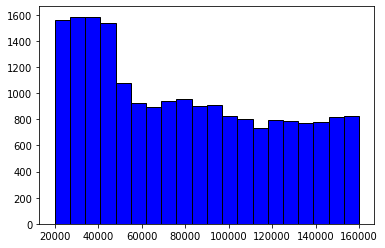

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
plt.hist(mobile['INCOME'], color = 'blue', edgecolor = 'black',bins = 20)
plt.show()

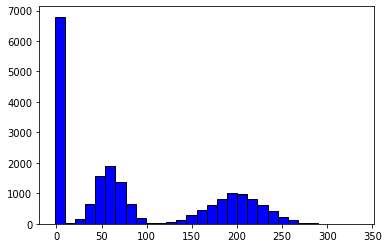

In [ ]:
plt.hist(mobile['OVERAGE'], color = 'blue', edgecolor = 'black',bins = 30)
plt.show()

#### 2단계 : 종속변수와 독립변수와의 관계

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


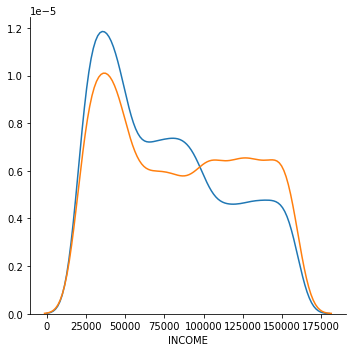

In [ ]:
import seaborn as sns 

g = sns.FacetGrid(data=mobile, hue='CHURN', size = 5)
g.map(sns.distplot, 'INCOME', kde=True, hist=False)


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


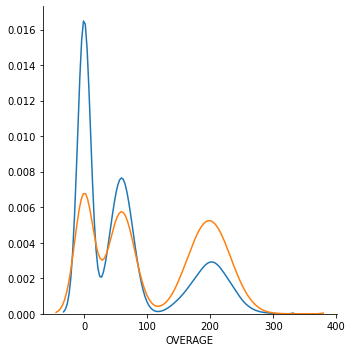

In [ ]:
g = sns.FacetGrid(data=mobile, hue='CHURN', size = 5)
g.map(sns.distplot, 'OVERAGE', kde=True, hist=False)


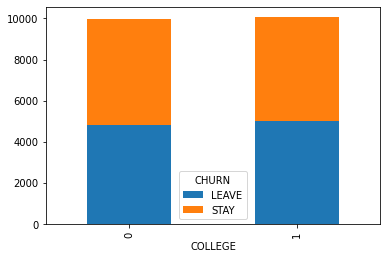

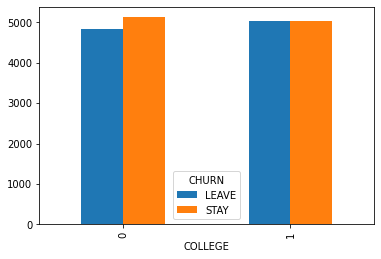

In [ ]:
gb_churn = mobile.groupby("COLLEGE")['CHURN'].value_counts().unstack()
gb_churn.plot(kind='bar', stacked='True')
gb_churn.plot(kind='bar')

#### 3단계 : 독립변수들 간의 관계 살펴보기

2단계와 방식은 같으나 해석이 달라집니다.

## 3. Data Preparation

준비해야 할 데이터의 형태는,  
* 모델링 할 수 있는
* 비즈니스 요구사항을 담아내는  

하나의 데이터프레임 형태!

### NA, 이상치 처리
이번 과정에서 다루지 않습니다만, 중요!

### 3.1 Dummy Variable

범주형(명목형) 변수에 대해 가변수화 한다.
그리고 사용하지 않을 변수들은 제거하자.


익혀야 할 방법들
pd.get_dummies, pd.concat, (Pandas Dataframe).drop

In [ ]:
# 범주형(명목형) 변수를 가변수로 만들고 붙여봅시다.
dummy_fields = ['REPORTED_SATISFACTION', 'REPORTED_USAGE_LEVEL','CONSIDERING_CHANGE_OF_PLAN']
for each in dummy_fields:
    dummies = pd.get_dummies(mobile[each], prefix=each, drop_first=False)
    mobile = pd.concat([mobile, dummies], axis=1)

mobile.head()

,id,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,REPORTED_SATISFACTION,REPORTED_USAGE_LEVEL,CONSIDERING_CHANGE_OF_PLAN,CHURN,REPORTED_SATISFACTION_avg,REPORTED_SATISFACTION_sat,REPORTED_SATISFACTION_unsat,REPORTED_SATISFACTION_very_sat,REPORTED_SATISFACTION_very_unsat,REPORTED_USAGE_LEVEL_avg,REPORTED_USAGE_LEVEL_high,REPORTED_USAGE_LEVEL_little,REPORTED_USAGE_LEVEL_very_high,REPORTED_USAGE_LEVEL_very_little,CONSIDERING_CHANGE_OF_PLAN_actively_looking_into_it,CONSIDERING_CHANGE_OF_PLAN_considering,CONSIDERING_CHANGE_OF_PLAN_never_thought,CONSIDERING_CHANGE_OF_PLAN_no,CONSIDERING_CHANGE_OF_PLAN_perhaps
0,1,0,31953,0,6,313378,161,0,4,unsat,little,no,STAY,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
1,2,1,36147,0,13,800586,244,0,6,unsat,little,considering,STAY,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
2,3,1,27273,230,0,305049,201,16,15,unsat,very_little,perhaps,STAY,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
3,4,0,120070,38,33,788235,780,3,2,unsat,very_high,considering,LEAVE,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
4,5,1,29215,208,85,224784,241,21,1,very_unsat,little,never_thought,STAY,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0


In [ ]:
# 불필요한 변수들 제거 : 가변수화 하기 전 변수, id, 일련번호 등.
fields_to_drop = ['id','REPORTED_SATISFACTION', 'REPORTED_USAGE_LEVEL','CONSIDERING_CHANGE_OF_PLAN']
data = mobile.drop(fields_to_drop, axis=1)
data.head()

,COLLEGE,INCOME,OVERAGE,LEFTOVER,HOUSE,HANDSET_PRICE,OVER_15MINS_CALLS_PER_MONTH,AVERAGE_CALL_DURATION,CHURN,REPORTED_SATISFACTION_avg,REPORTED_SATISFACTION_sat,REPORTED_SATISFACTION_unsat,REPORTED_SATISFACTION_very_sat,REPORTED_SATISFACTION_very_unsat,REPORTED_USAGE_LEVEL_avg,REPORTED_USAGE_LEVEL_high,REPORTED_USAGE_LEVEL_little,REPORTED_USAGE_LEVEL_very_high,REPORTED_USAGE_LEVEL_very_little,CONSIDERING_CHANGE_OF_PLAN_actively_looking_into_it,CONSIDERING_CHANGE_OF_PLAN_considering,CONSIDERING_CHANGE_OF_PLAN_never_thought,CONSIDERING_CHANGE_OF_PLAN_no,CONSIDERING_CHANGE_OF_PLAN_perhaps
0,0,31953,0,6,313378,161,0,4,STAY,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
1,1,36147,0,13,800586,244,0,6,STAY,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
2,1,27273,230,0,305049,201,16,15,STAY,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
3,0,120070,38,33,788235,780,3,2,LEAVE,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0
4,1,29215,208,85,224784,241,21,1,STAY,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0


### 3.2 split data

In [ ]:
# sklearn에서 제공하는 split 함수를 이용해보자. : train_test_split

from sklearn.model_selection import train_test_split

In [ ]:
# features와 y 분리
X = data.drop('CHURN', axis=1)
y = data.iloc[:, 8]

In [ ]:
# 먼저 전체에서 train : test = 8 : 2
train_x0, test_x, train_y0, test_y = train_test_split(X, y, test_size=0.3, random_state=1)

# train에서 train : validation = 8 : 2
train_x, val_x, train_y, val_y = train_test_split(train_x0, train_y0, test_size=0.2, random_state=1)


### 3.3 Scaling : min-max

이번에는 최소-최대값을 0~1 사이 값으로 변환시켜 보자.

In [ ]:
# 필요한 함수 불러오기
from sklearn.preprocessing import StandardScaler

# 선언하기
scaler = StandardScaler()

# 스케일링 함수 만들기(모델링?)
scaler.fit(train_x)

# 적용하기
train_x = scaler.transform(train_x)
val_x = scaler.transform(val_x)
test_X = scaler.transform(test_x)


In [ ]:
# 그러므로 Target만 np.array로....
train_y, val_y, test_y = train_y.values, val_y.values, test_y.values

In [ ]:
print(train_x.shape, train_y.shape)
print(val_x.shape, val_y.shape)
print(test_x.shape, test_y.shape)

(11200, 23) (11200,)
(2800, 23) (2800,)
(6000, 23) (6000,)


## 4. Modeling : Classification

### 4.1 KNN

In [5]:
# 필요한 알고리즘 불러오기
from sklearn.neighbors import KNeighborsClassifier

# 모델 선언
knn_cl = KNeighborsClassifier()

In [6]:
# 학습
knn_cl.fit(train_x, train_y)

NameError: ignored

In [7]:
# 예측 : train set과 validation set에 대해 예측 수행
knn_val_pred = knn_cl.predict(val_x)

NameError: ignored

In [8]:
# confusion matrix로 결과를 평가해 봅시다.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [9]:
accuracy_score(val_y, knn_val_pred)

NameError: ignored

In [10]:
print(confusion_matrix(val_y, knn_val_pred).T)

NameError: ignored

In [11]:
print(classification_report(val_y, knn_val_pred))

NameError: ignored

In [12]:
train_y.head()

NameError: ignored

## 5. 실습
### 5.1 knn

k 값을 조정하며 모델을 4개 만들고, 예측하고, 결과를 비교해봅시다.  
* k 값의 default는 5입니다.
* 일반적으로는 k 값을 찾기 위한 시작점으로 sqrt(rows) 으로 정하지만, 정답이 아니라 시작점임을 명심해야 합니다.

### 5.2 ANN

이번에는 ANN 알고리즘을 이용하여 분류 문제를 해결하시오.  
confusion matrix로 평가하시오.